In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler

In [5]:
url = "https://data.ojp.usdoj.gov/resource/ynf5-u8nk.csv"
df = pd.read_csv(url)

# Explore the dataset
print(df.head())
print(df.info())
print(df.describe())

   id gender   race age_at_release  residence_puma gang_affiliated  \
0   1      M  BLACK          43-47              16           False   
1   2      M  BLACK          33-37              16           False   
2   3      M  BLACK    48 or older              24           False   
3   4      M  WHITE          38-42              16           False   
4   5      M  WHITE          33-37              16           False   

   supervision_risk_score_first supervision_level_first  \
0                           3.0                Standard   
1                           6.0             Specialized   
2                           7.0                    High   
3                           7.0                    High   
4                           4.0             Specialized   

         education_level dependents  ... drugtests_meth_positive  \
0  At least some college  3 or more  ...                0.000000   
1   Less than HS diploma          1  ...                0.000000   
2  At least some col

In [6]:
# Drop columns
df = df.drop(columns=["id"])

# Convert categorical variables to dummy variables
df = pd.get_dummies(df, drop_first=True)

# Handle missing values if any
df = df.dropna()

# Define features and target variable
X = df.drop(
    columns=[
        "recidivism_within_3years",
        "recidivism_arrest_year1",
        "recidivism_arrest_year2",
        "recidivism_arrest_year3",
    ],
    axis=1,
)
y = df["recidivism_within_3years"]

print(len(df.columns))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

119


## Lasso Logistic Regression

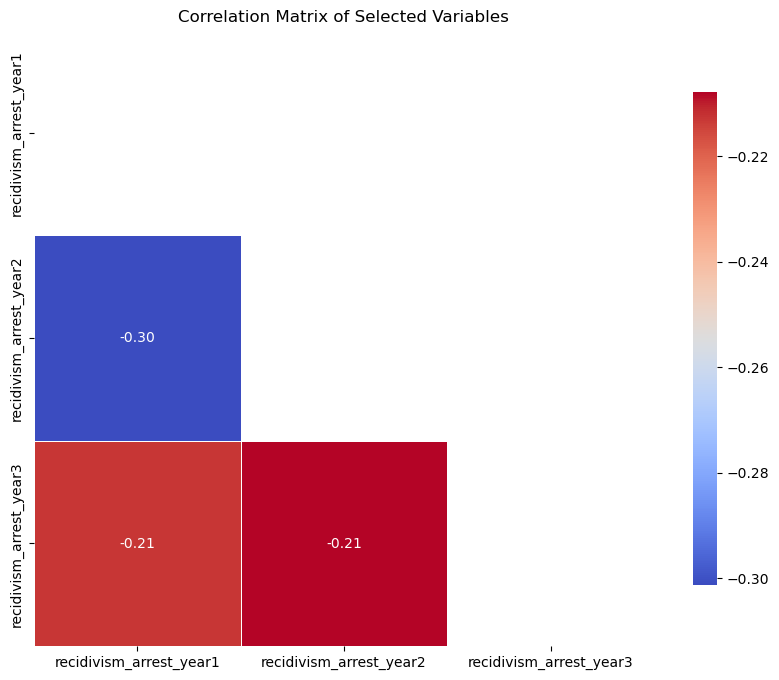

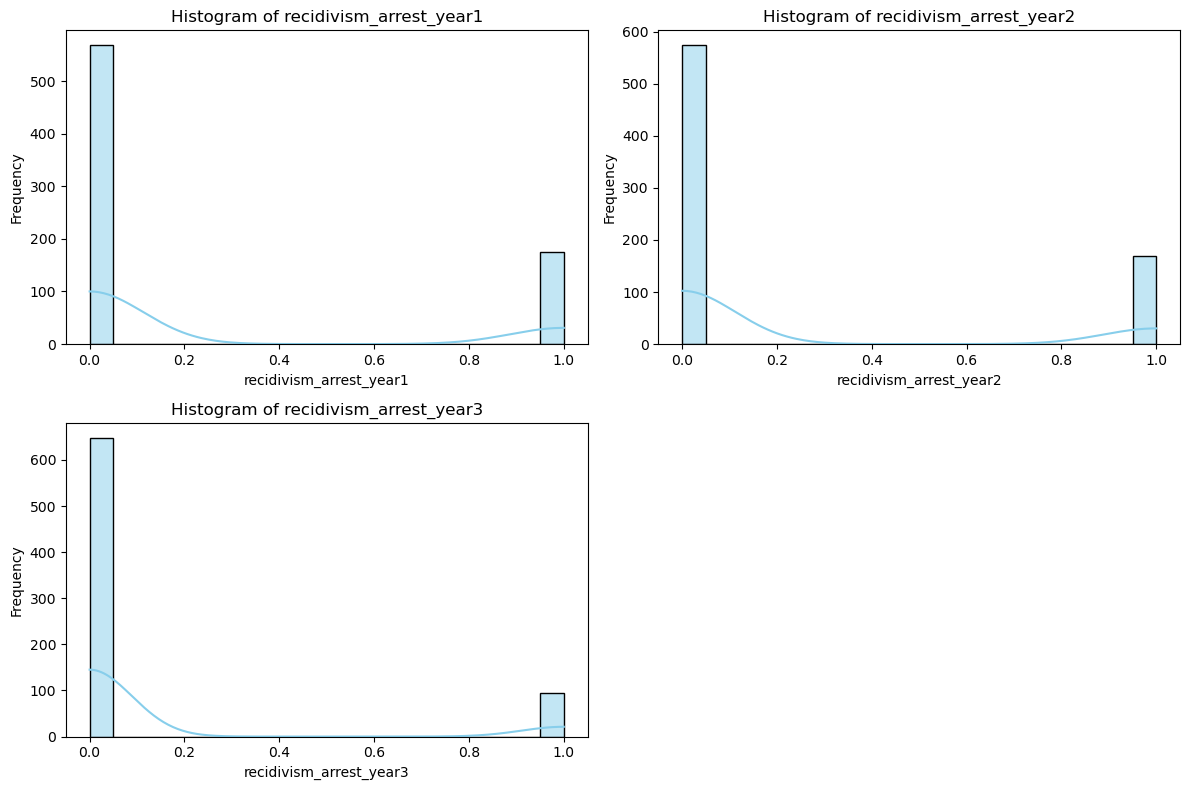

In [7]:
# Correlation Matrix
selected_vars = ["recidivism_arrest_year1", "recidivism_arrest_year2", "recidivism_arrest_year3"]
subset_df = df[selected_vars].astype(int)

correlation_matrix = df[selected_vars].corr()

# Set a threshold for correlation values
threshold = 0.5
highly_correlated = (correlation_matrix.abs() > threshold) & (correlation_matrix < 1)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Customize the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask, fmt=".2f", linewidths=.5, cbar_kws={"shrink": 0.8})

plt.title('Correlation Matrix of Selected Variables')
plt.show()

# Histogram Plots
plt.figure(figsize=(12, 8))

# Loop through selected variables and create histograms
for i, var in enumerate(selected_vars, 1):
    plt.subplot(2, 2, i)
    sns.histplot(subset_df[var], kde=True, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {var}")
    plt.xlabel(var)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [8]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Train the Lasso logistic regression model
lasso_model = LogisticRegression(penalty="l1", solver="liblinear", random_state=42)
lasso_model.fit(X_train_scaled, y_train)

# Print coefficients
coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": lasso_model.coef_[0]})
print(coef_df)

                                 Feature  Coefficient
0                         residence_puma    -0.039025
1           supervision_risk_score_first     0.000000
2                prior_arrest_episodes_1     0.036453
3                prior_arrest_episodes_2     0.078853
4            prior_conviction_episodes_2     0.178448
..                                   ...          ...
110          program_unexcusedabsences_2    -0.108559
111  program_unexcusedabsences_3 or more     0.118189
112                  residence_changes_1     0.000242
113                  residence_changes_2     0.061021
114          residence_changes_3 or more     0.367359

[115 rows x 2 columns]


In [10]:
# Select features based on non-zero coefficients
selected_features = X.columns[lasso_model.coef_[0] != 0]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

                                 Feature  Coefficient
0                         residence_puma    -0.039025
1           supervision_risk_score_first     0.000000
2                prior_arrest_episodes_1     0.036453
3                prior_arrest_episodes_2     0.078853
4            prior_conviction_episodes_2     0.178448
..                                   ...          ...
110          program_unexcusedabsences_2    -0.108559
111  program_unexcusedabsences_3 or more     0.118189
112                  residence_changes_1     0.000242
113                  residence_changes_2     0.061021
114          residence_changes_3 or more     0.367359

[115 rows x 2 columns]


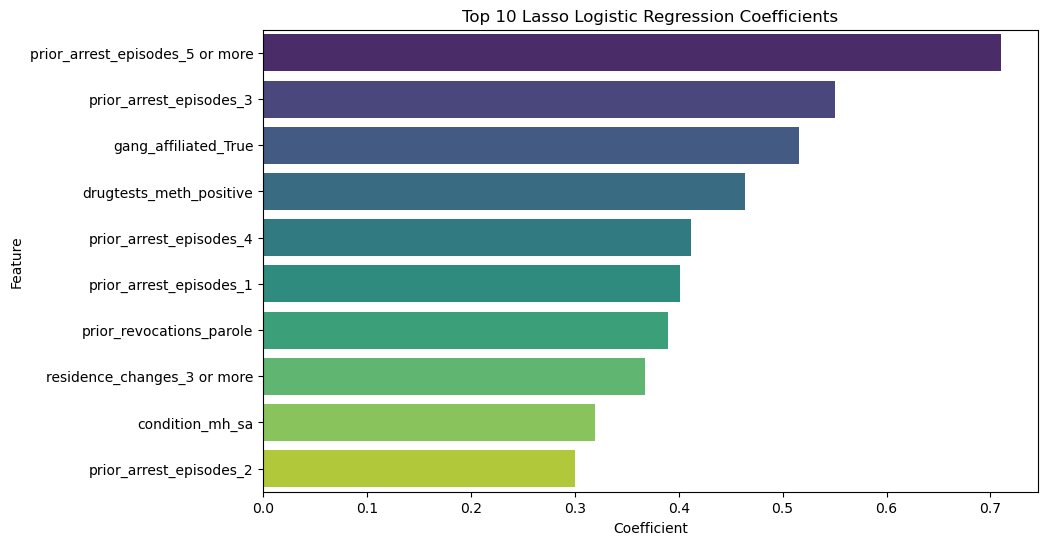

In [11]:
N = 10  # Number of top features to display
print(coef_df)
top_features = coef_df.nlargest(N, "Coefficient")

# Create a horizontal bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=top_features, palette="viridis")
plt.title(f"Top {N} Lasso Logistic Regression Coefficients")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()

In [12]:
# Predictions and Evaluation
y_pred = lasso_model.predict(X_test_scaled)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.54      0.55      0.55        82
        True       0.74      0.73      0.73       141

    accuracy                           0.66       223
   macro avg       0.64      0.64      0.64       223
weighted avg       0.66      0.66      0.66       223

[[ 45  37]
 [ 38 103]]


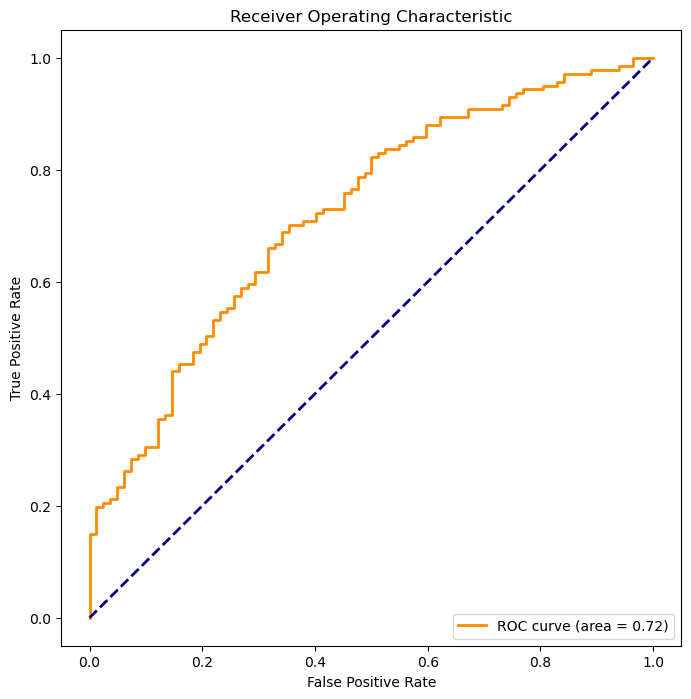

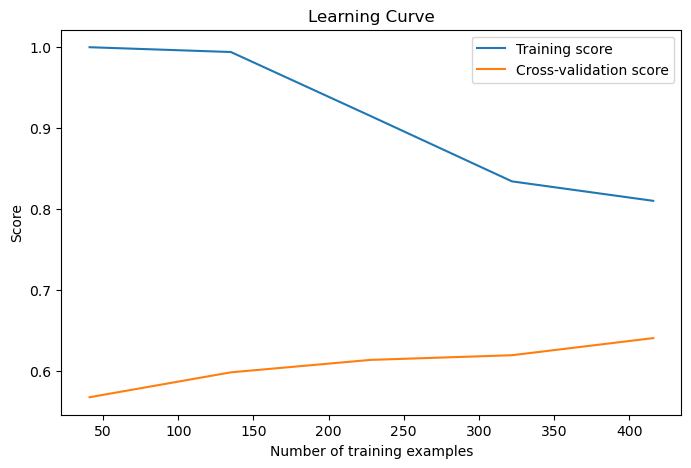

Best hyperparameters: {'C': 0.1}


LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='liblinear')

In [13]:
# ROC Curve
y_prob = lasso_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

# Learning Curves
train_sizes, train_scores, test_scores = learning_curve(
    lasso_model, X_train_scaled, y_train, cv=5
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.xlabel("Number of training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

# Hyperparameter Tuning (example with regularization strength)
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(
    LogisticRegression(penalty="l1", solver="liblinear", random_state=42), param_grid, cv=5
)
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Re-train the model with the best hyperparameters
best_lasso_model = grid_search.best_estimator_
best_lasso_model.fit(X_train_scaled, y_train)

## Decision Tree

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Train the Decision Tree model using GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt_model, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [17]:
# Re-train the model with the best hyperparameters
best_dt_model = grid_search.best_estimator_
best_dt_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=5,
                       random_state=42)

In [18]:
# Predictions and Evaluation
y_pred_dt = best_dt_model.predict(X_test_scaled)

# Print classification report and confusion matrix for Decision Tree
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Decision Tree Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

Decision Tree Classification Report:
              precision    recall  f1-score   support

       False       0.46      0.54      0.49        82
        True       0.70      0.63      0.66       141

    accuracy                           0.60       223
   macro avg       0.58      0.58      0.58       223
weighted avg       0.61      0.60      0.60       223

Decision Tree Confusion Matrix:
[[44 38]
 [52 89]]


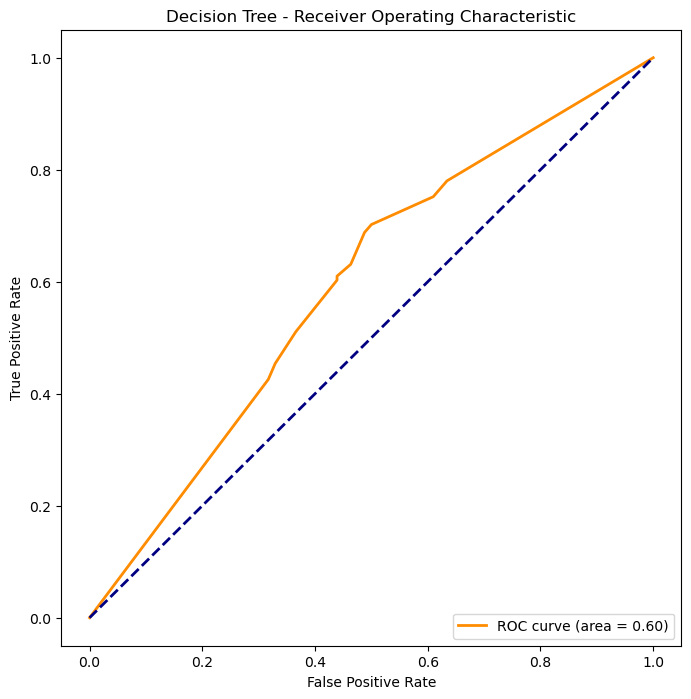

In [19]:
# ROC Curve for Decision Tree
y_prob_dt = best_dt_model.predict_proba(X_test_scaled)[:, 1]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Plot ROC Curve for Decision Tree
plt.figure(figsize=(8, 8))
plt.plot(fpr_dt, tpr_dt, color="darkorange", lw=2, label="ROC curve (area = {:.2f})".format(roc_auc_dt))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree - Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

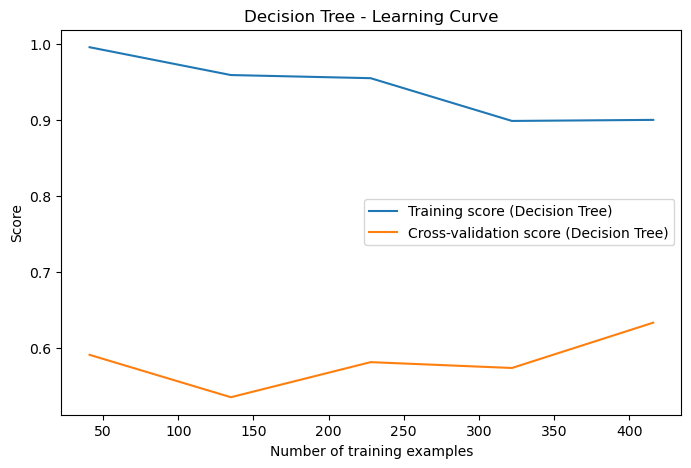

In [20]:
# Learning Curves for Decision Tree
train_sizes_dt, train_scores_dt, test_scores_dt = learning_curve(
    best_dt_model, X_train_scaled, y_train, cv=5
)
train_mean_dt = np.mean(train_scores_dt, axis=1)
test_mean_dt = np.mean(test_scores_dt, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes_dt, train_mean_dt, label="Training score (Decision Tree)")
plt.plot(train_sizes_dt, test_mean_dt, label="Cross-validation score (Decision Tree)")
plt.xlabel("Number of training examples")
plt.ylabel("Score")
plt.title("Decision Tree - Learning Curve")
plt.legend(loc="best")
plt.show()